
** Étape 2 : Machine Learning avec Scikit-Learn**

<span style="color : green">**3.1 Extraction de Caractéristiques**</span>

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HOG
    hog = cv2.HOGDescriptor()
    h = hog.compute(gray)
    hog_feat = h.flatten()

    # Histogramme de couleurs (RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # LBP (simplifié)
    lbp = ((gray >= np.roll(gray, 1, axis=0)).astype(np.uint8) * 1 +
           (gray >= np.roll(gray, -1, axis=0)).astype(np.uint8) * 2 +
           (gray >= np.roll(gray, 1, axis=1)).astype(np.uint8) * 4 +
           (gray >= np.roll(gray, -1, axis=1)).astype(np.uint8) * 8)
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 256))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-7)

    # SIFT (128-descriptor averaged)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    sift_feat = np.mean(des, axis=0) if des is not None else np.zeros(128)

    return np.concatenate([hog_feat[:128], hist[:128], lbp_hist[:128], sift_feat[:128]])
# Chargement des images et extraction des caractéristiques
features = []
labels = []
dataset_path = "./300_dataset/"

for label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label)
    if not os.path.isdir(class_path):
        continue
    for file in os.listdir(class_path):
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(class_path, file)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (128, 128))
            feat = extract_features(image)
            features.append(feat)
            labels.append(label)

In [ ]:
# Préparation des données
features = np.array(features)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

<span style="color: green">**3.2 Classification**</span>

In [ ]:
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "k-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    results[name] = model.score(X_test, y_test)


Model: SVM
[[45  5  1  2  5  6  1  1  2  5]
 [ 2 36  2  5  2  4  1  0 11  5]
 [ 3  4 29  4  3  3  4  1  1  7]
 [ 0  3  2 36  4  1  3  4  0  3]
 [ 1  3  1  2 42  2  1  2  2  3]
 [ 6  7  1  0  3 34  2  2  2  3]
 [ 0  2  2  2  2  2 39  0  2  5]
 [ 0  0  2  6  1  1  1 34  0  1]
 [ 0  4  1  3  2  3  4  1 39  2]
 [ 1  3  3  2  0  1  7  2  1 44]]
              precision    recall  f1-score   support

           0       0.78      0.62      0.69        73
           1       0.54      0.53      0.53        68
           2       0.66      0.49      0.56        59
           3       0.58      0.64      0.61        56
           4       0.66      0.71      0.68        59
           5       0.60      0.57      0.58        60
           6       0.62      0.70      0.66        56
           7       0.72      0.74      0.73        46
           8       0.65      0.66      0.66        59
           9       0.56      0.69      0.62        64

    accuracy                           0.63       600
   macr

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,


Model: Logistic Regression
[[41  2  7  5  1  5  3  5  1  3]
 [ 4 30  1  9  2  9  1  2  7  3]
 [ 3  3 27  0  1  4 10  2  3  6]
 [ 0  1  2 31  4  3  3  3  5  4]
 [ 2  6  2  6 33  1  3  3  2  1]
 [ 9  4  2  0  3 30  2  1  7  2]
 [ 3  1  2  1  3  2 34  1  2  7]
 [ 0  0  2  4  1  1  1 35  0  2]
 [ 1  4  2  3  2  2  4  1 38  2]
 [ 3  5  4  1  2  0  7  1  3 38]]
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        73
           1       0.54      0.44      0.48        68
           2       0.53      0.46      0.49        59
           3       0.52      0.55      0.53        56
           4       0.63      0.56      0.59        59
           5       0.53      0.50      0.51        60
           6       0.50      0.61      0.55        56
           7       0.65      0.76      0.70        46
           8       0.56      0.64      0.60        59
           9       0.56      0.59      0.58        64

    accuracy                           0.56  

<Span style="color:green">**3.3 Évaluation**</span>

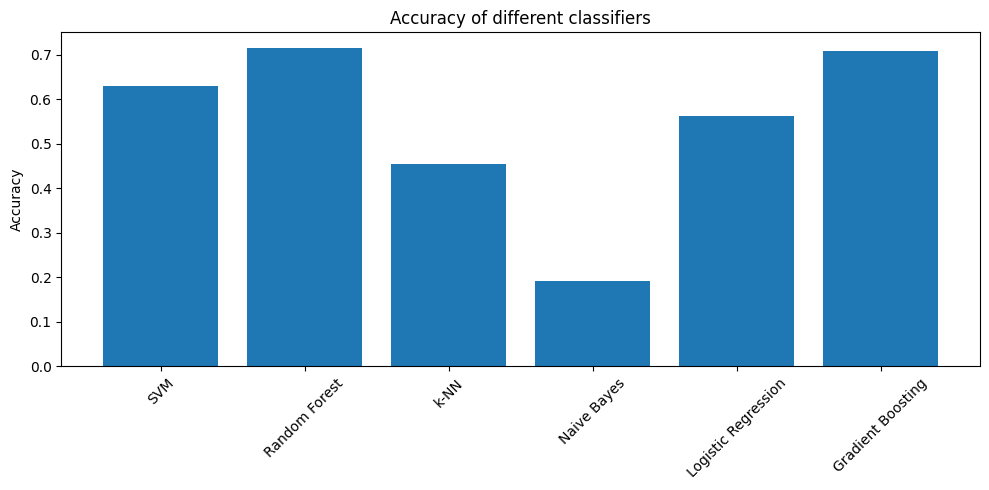

<Figure size 640x480 with 0 Axes>

In [ ]:

plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values())
plt.title("Accuracy of different classifiers")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("model_comparison.png")


## Partie 3 : Réseaux de Neurones Simples (MLP)

<span style="color: green">**4.2 Modélisation**</span>

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', max_iter=300)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)

<span style=" color: green">**4.3 Interprétation**</span>

In [ ]:


mlp_pred = mlp.predict(X_test)
print("\nMLP Classification Report:")
print(classification_report(y_test, mlp_pred))
results["MLP"] = mlp.score(X_test, y_test)



MLP Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68        73
           1       0.62      0.56      0.59        68
           2       0.61      0.53      0.56        59
           3       0.61      0.70      0.65        56
           4       0.63      0.68      0.66        59
           5       0.75      0.60      0.67        60
           6       0.58      0.70      0.63        56
           7       0.78      0.83      0.80        46
           8       0.72      0.73      0.72        59
           9       0.65      0.69      0.67        64

    accuracy                           0.66       600
   macro avg       0.66      0.67      0.66       600
weighted avg       0.66      0.66      0.66       600



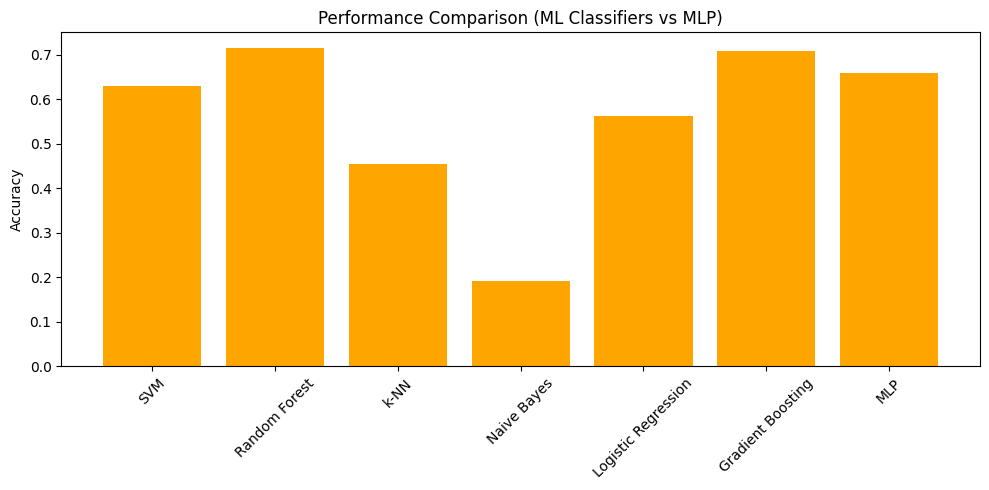

<Figure size 640x480 with 0 Axes>

In [ ]:
# Affichage final des performances
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color='orange')
plt.title("Performance Comparison (ML Classifiers vs MLP)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("performance_comparison_MlvsMLP.png")


Partie 4 : Réseaux de Neurones Convolutionnels (CNN)


<span style="color: green">**5.1 Architecture CNN**</span>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image
import os

# --- Parameters ---
num_classes = 10
batch_size = 32
epochs = 50
input_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Custom Image Loader ---
def pil_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        # Return blank image as fallback
        return Image.new('RGB', (input_size, input_size), (0, 0, 0))

# --- CNN Architecture ---
class LeafCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (input_size//8) * (input_size//8), 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- Data Preparation ---
transform_train = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset with error handling
dataset = datasets.ImageFolder(
    './300_dataset',
    transform=transform_train,
    loader=pil_loader
)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply different transform to validation
val_dataset.dataset.transform = transform_val

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


<span style="color: green">**5.2 Entraînement**</span>

In [ ]:


# --- Training Setup ---
model = LeafCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# --- Training Loop ---
best_val_acc = 0
for epoch in range(epochs):
    model.train()
    train_loss, train_correct = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    # Calculate metrics
    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    # Update scheduler
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc*100:.2f}%")

results["CNN"] = best_val_acc

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


<span style="color: green">**5.3 Comparaison et Interprétationt**</span>

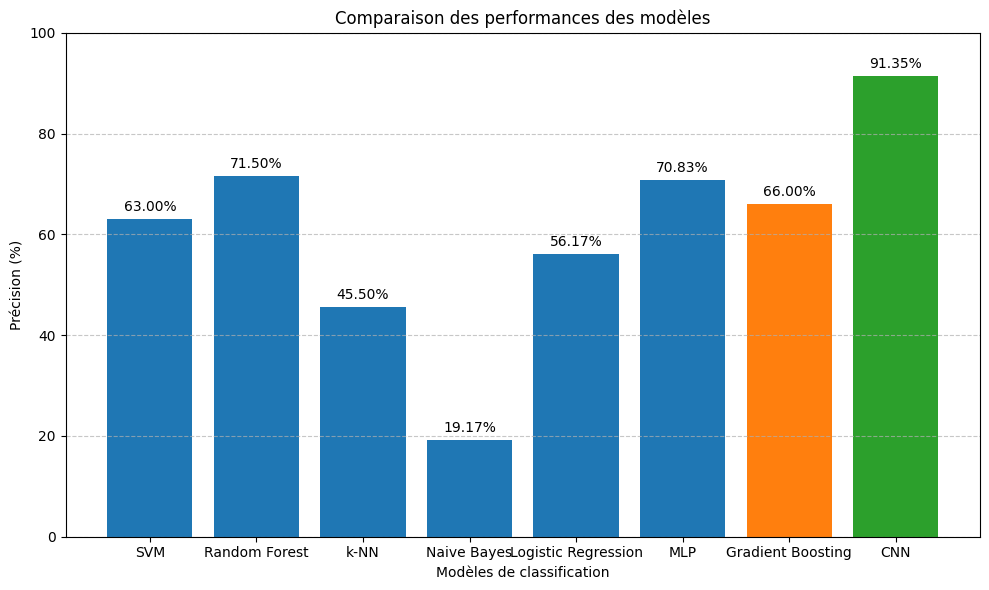

In [ ]:
import matplotlib.pyplot as plt

# Noms des modèles
models = ['SVM', 'Random Forest', 'k-NN', 'Naive Bayes', 'Logistic Regression', 'MLP', 'Gradient Boosting', 'CNN']

# Précisions simulées en %

accuracies = [acc * 100 for acc in results.values()]

# Couleurs pour différencier les groupes
colors = ['#1f77b4'] * 6 + ['#ff7f0e', '#2ca02c']  # classiques, MLP, CNN

# Création du graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,  f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

# Esthétique du graphique
plt.ylim(0, 100)
plt.title("Comparaison des performances des modèles")
plt.ylabel("Précision (%)")
plt.xlabel("Modèles de classification")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



"